The stakeholder ist Amy Williams. Sie is a Mafiosi Seller of several central houses(top10%) over time, she needs average outskirt houses over time to hide from the FBI. I assume she has those already and doenst need to buy those.

I derive two needs: 
Sell central top houses for profit over the year
Keep average outskirt houses for safety by density

In [2]:
# Install Modules
!pip install scikit-learn

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [60]:
# Load Data
#file_path = 'data/King_County_House_prices_dataset.csv'  
data = pd.read_csv('data/King_County_House_prices_dataset.csv')

1. take a look at the data

2.  clean the data
-   Date Parsing: Converted the date column to a datetime format to enable seasonal analysis (by extracting the year and month).
-   Density Calculations: Created a density_score to approximate density using sqft_living15 (average living space of 15 surrounding homes) and sqft_lot15 (average lot size of 15 surrounding properties).
-   Formula: density_score = sqft_living15 / sqft_lot15. A higher density_score indicates a denser (more central) area.
3.  treat NuN
-   in this case we can change all NuN to 0, since they only appear in categories that are not to be calculated with.

In [61]:
# take a look at data
data.head(), data.columns

(           id        date     price  bedrooms  bathrooms  sqft_living  \
 0  7129300520  10/13/2014  221900.0         3       1.00         1180   
 1  6414100192   12/9/2014  538000.0         3       2.25         2570   
 2  5631500400   2/25/2015  180000.0         2       1.00          770   
 3  2487200875   12/9/2014  604000.0         4       3.00         1960   
 4  1954400510   2/18/2015  510000.0         3       2.00         1680   
 
    sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
 0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
 1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
 2     10000     1.0         0.0   0.0  ...      6         770            0.0   
 3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
 4      8080     1.0         0.0   0.0  ...      8        1680            0.0   
 
   yr_built  yr_renovated  zipcode      lat     long  sqft_living1

In [62]:
# take a look at the data
# parse Date from the columns date according to purpose
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
# check, did it work?

<Axes: >

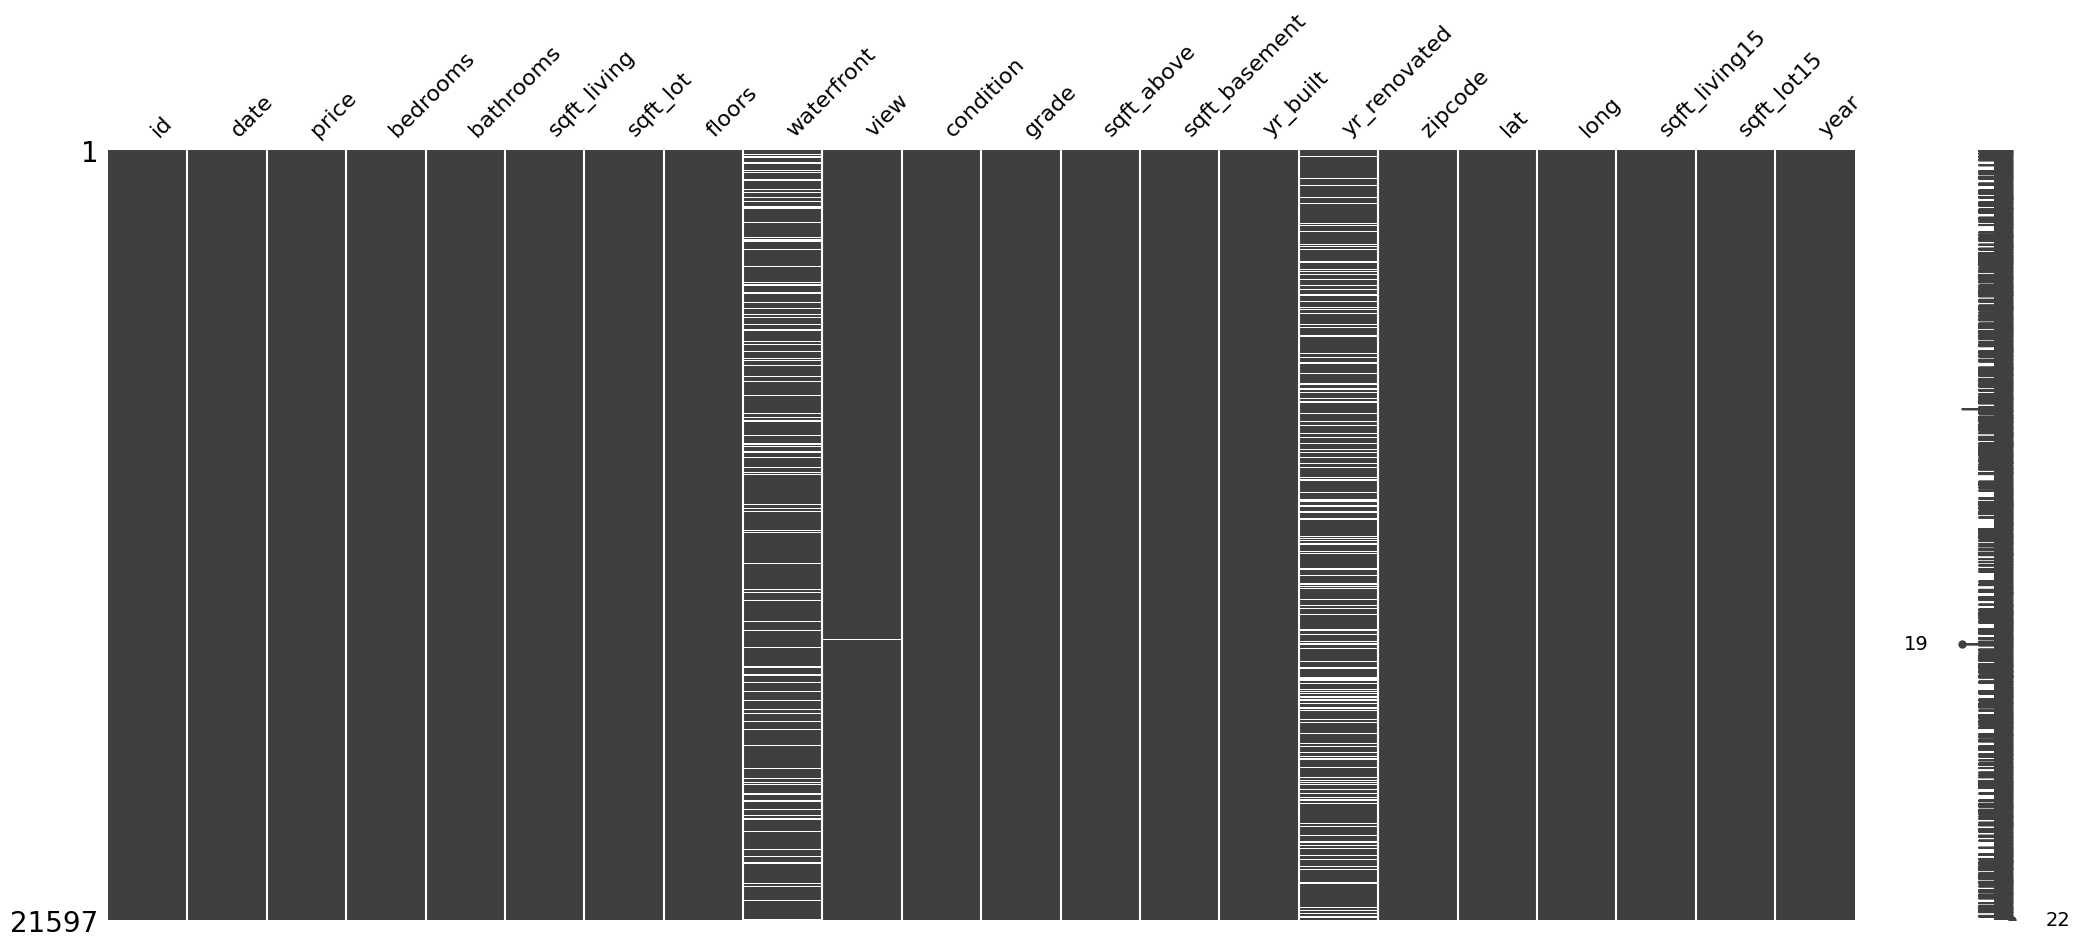

In [6]:
# treat NuN
# checking for missing data
import missingno as msno
data.isna().sum()
msno.matrix(data) 
# there are missing Data in waterfront, view, and yr_renovated - I assume the missing data indicate there is no information: no waterfront, no view or no renovation. Filling those Nun with 0 will not change any calculations 


<Axes: >

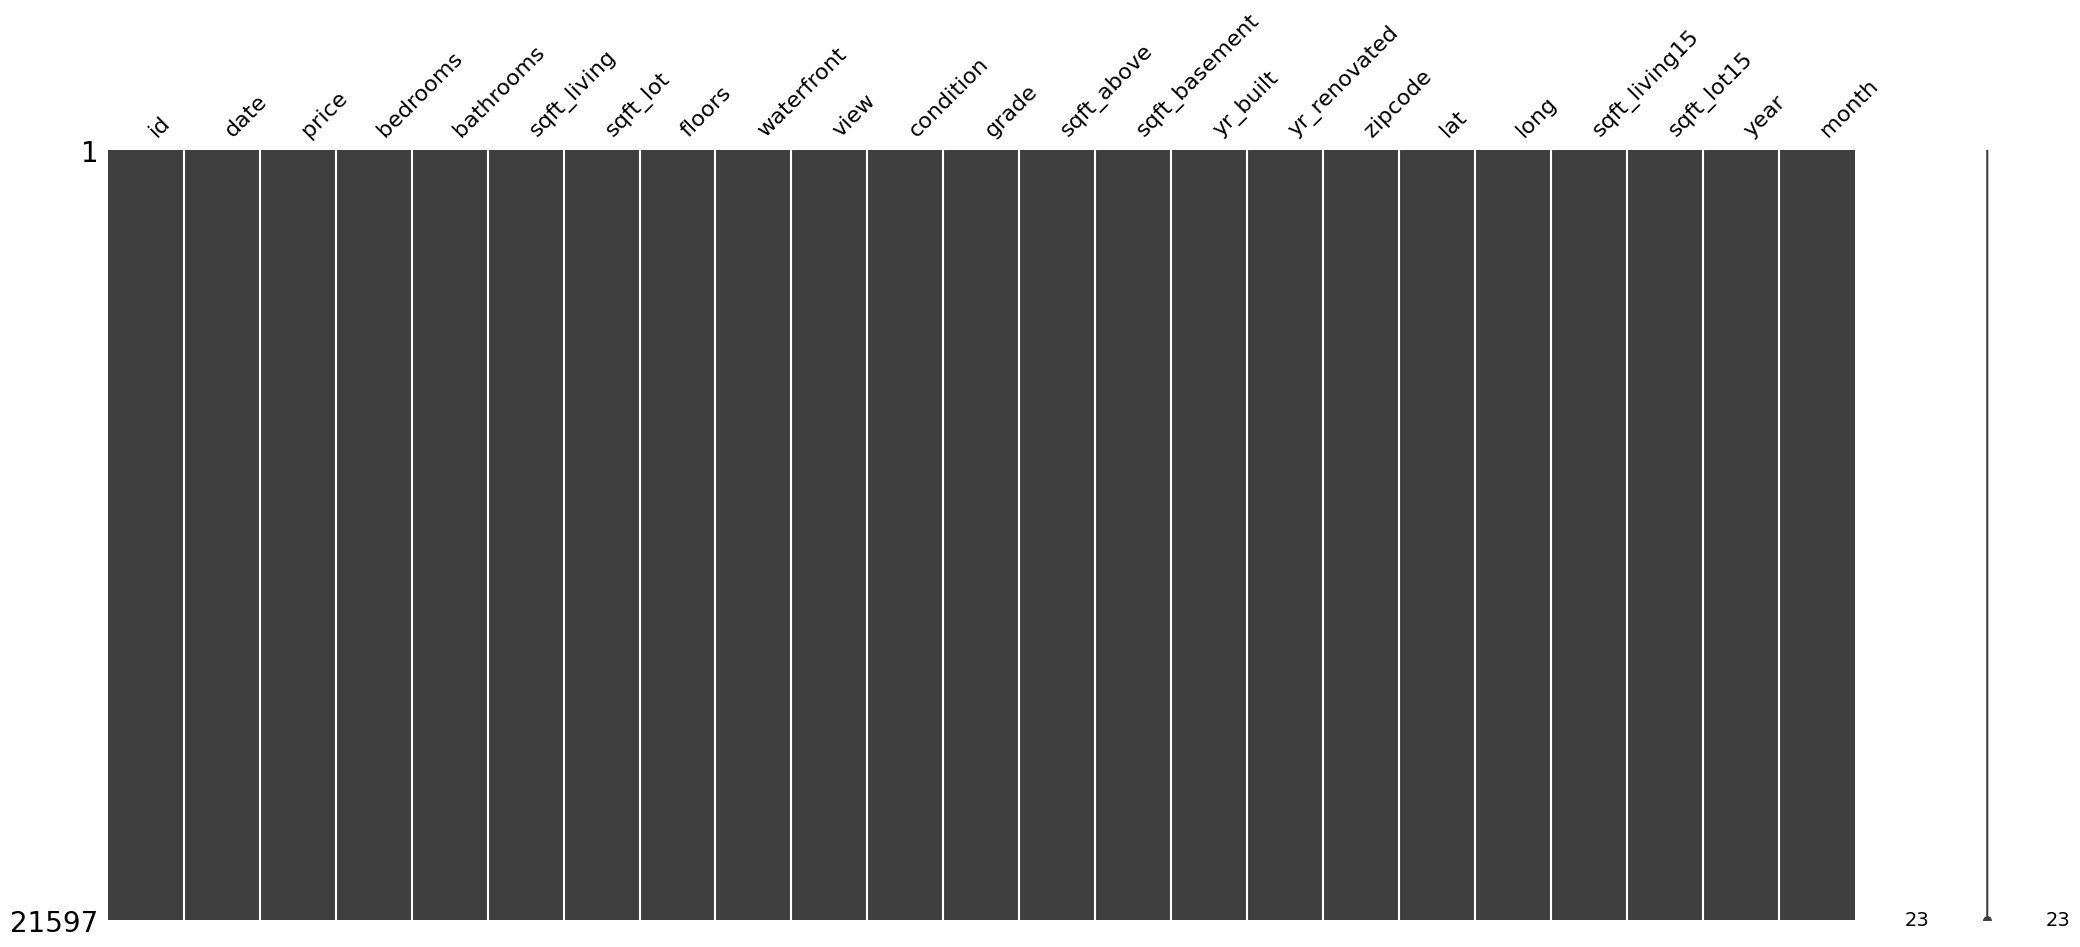

In [63]:
#Fill the Nun will the value 0
dfc = data.copy() # safetycopy

data.fillna(0, inplace=True)
data.reset_index(inplace=True, drop=True)
msno.matrix(data)

The Customer: Mafiosi, sells several central houses(top10%) over time, needs average outskirt houses over time to hide from the FBI

So the most important issue ist safety. Filter für remote properties, find their zipcodes describe average attributes.
Recommendation is: Keep the houses in these remote zip codes, with those attributes

The second issue is getting most money out of the top 10% of porperties in central areas. Filter for central zipcodes. Sort properties by price and filter for top 10%. Find the best time in the year to sell those.
Recommendation is: Sell the houses in those lively zipcodes in this times of the year for maximum price (3 categories?)

leave the rest for later

In [64]:
# Calculate density score based on surrounding living area and lot size so the bigger the score, the higher the density. Maximum is 1.
data['density_score'] = data['sqft_living15'] / data['sqft_lot15']

# Define central and remote areas based on density score thresholds
central_threshold = data['density_score'].quantile(0.75)
remote_threshold = data['density_score'].quantile(0.25)
data['area_type'] = data['density_score'].apply(lambda x: 'Central' if x >= central_threshold else ('Remote' if x <= remote_threshold else 'Intermediate'))

data['area_type']

0        Intermediate
1        Intermediate
2        Intermediate
3        Intermediate
4        Intermediate
             ...     
21592         Central
21593    Intermediate
21594         Central
21595         Central
21596         Central
Name: area_type, Length: 21597, dtype: object

In [65]:
# filter for remote areas, and the top 5 zip codes with most of them
suburban_properties = data[data['area_type'] == 'Remote']
# find the ten Zip Codes with most number of remote properties
rem_zip = suburban_properties['zipcode'].value_counts()
top_rem_zip = rem_zip.nlargest(5)

# Filter for properties in the top 10 remote zip codes
top_rem_zip_list = top_rem_zip.index  # Extract zip code values from the Series
filtered_data = data[data['zipcode'].isin(top_rem_zip_list)]

# Calculate the mean for numeric attributes
mean_composition_per_zipcode = filtered_data.groupby('zipcode')[mean_attributes].mean()

# Calculate the mode for categorical attributes
mod_composition_per_zipcode = filtered_data.groupby('zipcode')[mod_attributes].agg(lambda x: x.mode().iloc[0])

# Combine the results for a complete composition
composition_per_zipcode = pd.concat([mean_composition_per_zipcode, mod_composition_per_zipcode], axis=1)

# Display the result
print(composition_per_zipcode)

         sqft_living      sqft_lot          price  bedrooms  bathrooms  \
zipcode                                                                  
98042    1981.696527  18974.215722  311580.336380         3        2.5   
98053    2620.238213  35596.585608  677215.034739         4        2.5   
98072    2371.673993  30767.747253  570073.520147         3        2.5   
98155    1786.614350  10284.674888  423736.905830         3        1.0   
98168    1468.624535  11269.843866  240328.371747         3        1.0   

         floors  view  waterfront  yr_built  
zipcode                                      
98042       1.0   0.0         0.0      1969  
98053       2.0   0.0         0.0      2004  
98072       1.0   0.0         0.0      1976  
98155       1.0   0.0         0.0      1948  
98168       1.0   0.0         0.0      1942  


In those 5 zip codes are the most remote properties. Of those here is a list of the most common attributes per Zipcode. 
Recomenation: find a property close to those attributes in one oder each of the zipcodes for hideouts.

After the matter of safety is covered, here are the recomendations to get the best mony out of your top 10% central properties.
Filter for those properties in central areas, that have a price, that is higher than 90% of all sold properties in that time
For easier search we will fokus in the 5 Zipcpdes with most of those most expensive houses.
We want to find the best time of the year to sell those houses - are there relevant factors to wait for with the sale?

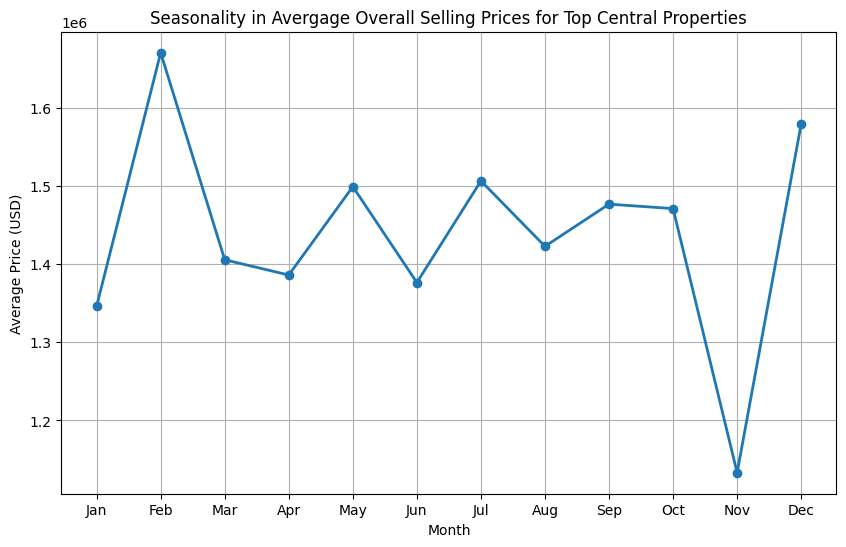

In [72]:
# filter for central areas, and the top 10% by price 
central_properties = data[data['area_type'] == 'Central']
# find the ten Zip Codes with most number of expensive central properties
th_cen_top_price = central_properties['price'].quantile(0.9)
# Step 3: Filter for the top 10% expensive properties
top_central_properties = central_properties[central_properties['price'] >= th_cen_top_price]
# Step 4: Group by zip code and count the number of top 10% properties
top_central_zipcodes = top_central_properties['zipcode'].value_counts().nlargest(5).index
# Display the result
# Focus on the top 5 zip codes with most expensive central properties
focused_properties = top_central_properties[top_central_properties['zipcode'].isin(top_central_zipcodes)]
focused_properties
# Analyze seasonality - group by month
monthly_avg_price = focused_properties.groupby('month')['price'].mean()

# Plot average monthly prices to identify seasonality
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price.index, monthly_avg_price.values, marker='o', linestyle='-', linewidth=2)
plt.title("Seasonality in Avergage Overall Selling Prices for Top Central Properties")
plt.xlabel("Month")
plt.ylabel("Average Price (USD)")
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


In [ ]:

# Step 5: Evaluate other factors
premium_factors = focused_properties[['view', 'waterfront', 'yr_renovated']]
premium_summary = premium_factors.describe()

# Display premium factor summary
print("Premium Factor Summary for Central Expensive Properties:")
print(premium_summary)

/tmp/ipykernel_3824/1826914759.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_price_by_type = data.groupby(['month', 'property_type'])['price'].mean().unstack()


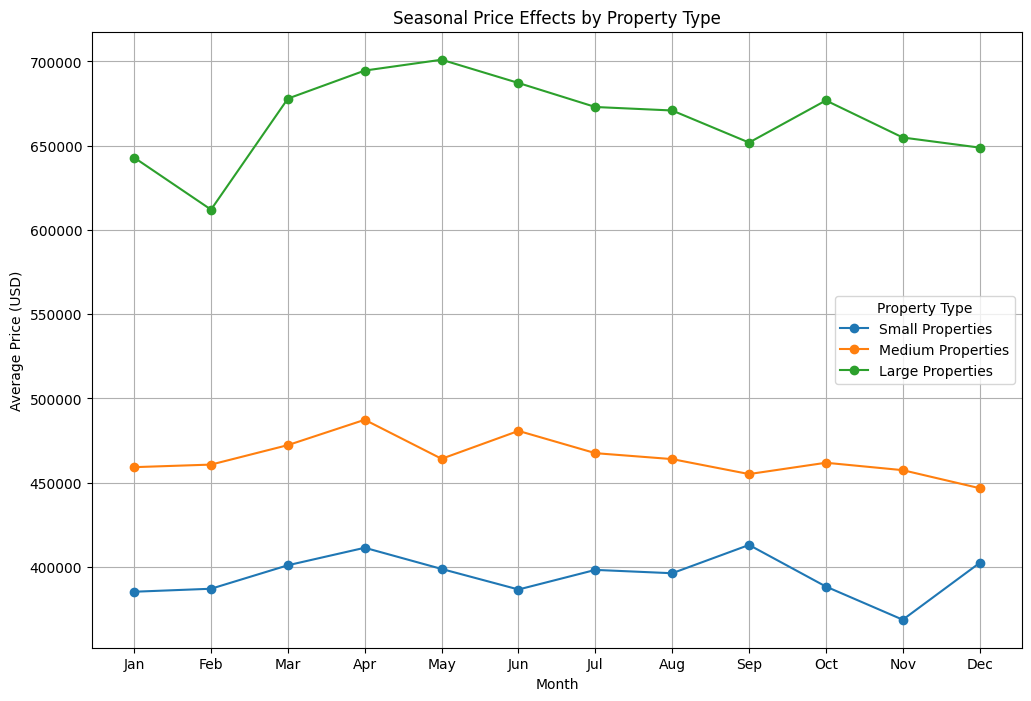

In [8]:
# Define property types based on bedroom count
# We'll categorize properties as follows:
# - Small (1-2 bedrooms)
# - Medium (3 bedrooms)
# - Large (4+ bedrooms)

data['property_type'] = pd.cut(data['bedrooms'], bins=[0, 2, 3, float('inf')], labels=['Small', 'Medium', 'Large'])

# Calculate the monthly average price for each property type
monthly_avg_price_by_type = data.groupby(['month', 'property_type'])['price'].mean().unstack()

# Plotting monthly average price trends by property type to observe seasonal effects
plt.figure(figsize=(12, 8))
for property_type in monthly_avg_price_by_type.columns:
    plt.plot(monthly_avg_price_by_type.index, monthly_avg_price_by_type[property_type], marker='o', linestyle='-', 
             label=f"{property_type} Properties")

plt.title("Seasonal Price Effects by Property Type")
plt.xlabel("Month")
plt.ylabel("Average Price (USD)")
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Property Type")
plt.grid(True)
plt.show()


In [36]:
# Finding the peak month(s) with the highest average price for suburban areas - we dont need that here, but we will for central areas!
suburb_peak_month = monthly_avg_price_suburbs.idxmax()
suburb_peak_month_price = monthly_avg_price_suburbs.max()
suburb_peak_month, suburb_peak_month_price


NameError: name 'monthly_avg_price_suburbs' is not defined

Lets try to get more info about the distribution of those areas mapwise: